In [1]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, time, timedelta
from sklearn.model_selection import train_test_split
from resampler import ResampleData
from strategy import TradingStrategy

In [2]:
def plot_df(df):
    plt.figure(figsize=(8,4))
    plt.plot(df['close'], label='Close')
    plt.title('Close Price Over Time')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.grid(True)
    plt.show()

In [3]:
def summarize_trade_results(trade_results, strategy_name):
    total_win = sum(x for x in trade_results['profits'] if x > 0)
    total_loss = -sum(x for x in trade_results['profits'] if x < 0)
    profit_factor = total_win / total_loss if total_loss != 0 else 0

    long_win_rate = sum(1 for x in trade_results['long_profits'] if x > 0) / len(trade_results['long_profits']) if trade_results['long_profits'] else 0
    short_win_rate = sum(1 for x in trade_results['short_profits'] if x > 0) / len(trade_results['short_profits']) if trade_results['short_profits'] else 0
    net_profit = sum(trade_results['profits'])

    # Print and log the statistics
    lines = [
        f"Strategy: {strategy_name}",
        f"Total trade Num: {len(trade_results['profits'])}",
        f"Net Profit: {net_profit:.2f}",
        f"Profit Factor: {profit_factor:.2f}",
        f"Long Trade Num: {len(trade_results['long_profits'])}",
        f"Long Win Rate: {long_win_rate:.2f}",
        f"Short Trade Num: {len(trade_results['short_profits'])}",
        f"Short Win Rate: {short_win_rate:.2f}\n"
    ]
    
    for line in lines:
        print(line)
        logging.info(line)

    # Create cumulative return series
    cumulative_returns = np.cumsum(trade_results['profits'])
    cumulative_long_returns = np.cumsum(trade_results['long_profits'])
    cumulative_short_returns = np.cumsum(trade_results['short_profits'])

    # Plot the results
    plt.figure(figsize=(8,4))
    plt.plot(cumulative_returns, label='Total Returns')
    plt.title("Cumulative Total Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(8,4))
    plt.plot(cumulative_long_returns, label='Long Returns', color='blue')
    plt.plot(cumulative_short_returns, label='Short Returns', color='red')
    plt.title("Cumulative Long and Short Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
# Initialize portfolio state
def init_portfolio():
    return {
        'position': None,  # "long" or "short"
        'entry_price': None,
        'entry_point': 0,
        'trailing_stop': 0,
        'take_profit': None,
        'stop_loss': None
    }

def trade_logic(df, trade_conditions_func):
    df = df.reset_index(drop=True)

    # Initialize trade_results
    trade_results = {
        'profits': [],
        'long_profits': [],
        'short_profits': [],
    }

    portfolio = init_portfolio()

    # Loop through the data
    for i in range(0, len(df)):
        profit = 0

        data_row = df.iloc[i]
        action = trade_conditions_func(df, i, portfolio)

        if portfolio['position'] is not None:
            if action == 'exit_long':
                trade_results['profits'].append(portfolio['profit'])
                trade_results['long_profits'].append(portfolio['profit'])
                portfolio = init_portfolio()

            if action == 'exit_short':
                trade_results['profits'].append(portfolio['profit'])
                trade_results['short_profits'].append(portfolio['profit'])
                portfolio = init_portfolio()

            else:
                trade_results['profits'].append(profit)
        
        elif action == 'entry_long':
            trade_results['profits'].append(profit)
            portfolio['position'] = 'long'

        elif action == 'entry_short':
            trade_results['profits'].append(profit)
            portfolio['position'] = 'short'

        else:
            trade_results['profits'].append(profit)

    return trade_results

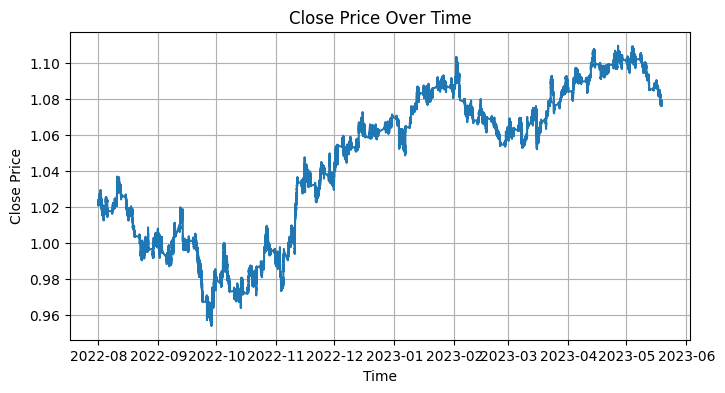

UnboundLocalError: cannot access local variable 'portfolio' where it is not associated with a value

In [5]:
# Backtest
file_name = '../csv/EURUSD_1_20220801_to_20230801.csv'

df = pd.read_csv(file_name)
resampler_df = ResampleData(df)
df = resampler_df.merge_data()

# Assume 80% of the data is used for training and 20% for testing
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

# Generate the log filename with current timestamp
log_filename = datetime.now().strftime('../log/%Y-%m-%d-%H-%M.log')

if __name__ == '__main__':
    # Logging configuration
    logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(message)s')
    logging.info(f'{file_name}\n')

    # Specify the DataFrame to be used in the backtest
    df = train_df
    #df = test_df

    strategy = TradingStrategy()
    df = strategy.prepare_data(df)
    plot_df(df)
    # display(df)

    trade_conditions = [
        (strategy.trade_conditions_func, "trend line trade"),
    ]

    # Execute the trade logic
    for trade_condition, description in trade_conditions:
        result = trade_logic(df, trade_condition)
        summarize_trade_results(result, description)
